In [36]:
import gym
import random
from itertools import zip_longest
import matplotlib.pyplot as plt

In [37]:
# Utilidades
def recompensa(elem):
    return elem['recompensa']

def melhorIndividuo(populacao):
    populacao.sort(key = recompensa)
    return populacao[0]['recompensa']

def imprime(individuos):
    print('Número de indivíduos: ', len(individuos))
    soma = 0
    for individuo in individuos:
        print(individuo['recompensa'])
        soma += individuo['recompensa']
    print('Média da população: ', soma/len(individuos))

In [38]:
# Adaptação
def fitness(individuo, ambiente):
    for acao in individuo['acoes']:
        obs, rec, fim, info = ambiente.step(acao)
        
        if rec > individuo['recompensa']:
            individuo['recompensa'] = rec
            
    return individuo['recompensa']

def adaptacao(populacao, ambiente):
    for individuo in populacao:
        fitness(individuo, ambiente)
    populacao.sort(key = recompensa, reverse = True)
    return

In [39]:
# Criar indivíduo aleatório (um indivíduo é um conjunto de ações)
def criaIndividuo(ambiente, num_acoes):
    individuo = { 'acoes': [], 'recompensa': -1000 }
    for i in range(num_acoes):
        individuo['acoes'].append(ambiente.action_space.sample())
    individuo['recompensa'] = fitness(individuo, ambiente)
    return individuo

In [40]:
# Criar população inicial
def criaPopulacao(ambiente, tam_pop, num_acoes):
    populacao = []
    for i in range(tam_pop):
        populacao.append(criaIndividuo(ambiente, num_acoes))
    return populacao

def analisePopInicial(populacao):
    negativo = True
    em_pe = True
    for individuo in populacao:
        if individuo['recompensa'] == -100:
            em_pe = False
            break
    return em_pe

In [41]:
# Seleção 
def naoCaiu(individuo):
    return individuo['recompensa'] != -100

def selecao(populacao, ambiente):
    adaptacao(populacao, ambiente)
    melhores = list(filter(naoCaiu, populacao))
    if(len(melhores) == len(populacao)):
        metade = int(len(melhores)/2)
        melhores = melhores[0:metade]
    return melhores

In [42]:
# Reprodução
def crossingOver(individuo1, individuo2, num_acoes):
    metade = int((num_acoes/2) + 1)

    corte1 = slice(0, metade)
    corte2 = slice(metade+1, num_acoes)

    filho1 = { 'acoes': [], 'recompensa': -100 }
    filho2 = { 'acoes': [], 'recompensa': -100 }

    gene12 = individuo1['acoes'][corte1] + individuo2['acoes'][corte2]
    gene21 = individuo2['acoes'][corte1] + individuo1['acoes'][corte2]

    filho1['acoes'] = gene12
    filho2['acoes'] = gene21

    return filho1, filho2

def reproducao(pais, num_acoes, cruzamentos):
    filhos = []
    
    for i in range(cruzamentos):
        n1 = random.randint(0, len(pais)-1)
        n2 = random.randint(0, len(pais)-1)
        co = crossingOver(pais[n1], pais[n2], num_acoes)
        filhos.append(co[0])
        filhos.append(co[1])
    
    return filhos

In [43]:
# Mutação
def mutacao(individuo, ambiente, num_acoes):
    if random.randint(0, 1):
        acao = ambiente.action_space.sample()
        posicao = random.randint(0, num_acoes-1)
        individuo['acoes'][posicao] = acao
    return

In [48]:
# Algoritmo genético
def algoritmo_genetico(tam_pop, num_acoes, mostrar, passos):
    ambiente = gym.make('BipedalWalker-v2')
    
    ambiente.reset()
    populacao = criaPopulacao(ambiente, tam_pop, num_acoes)
    adaptacao(populacao, ambiente)
    while(not analisePopInicial(populacao)):
        ambiente.reset()
        populacao = criaPopulacao(ambiente, tam_pop, num_acoes)
        adaptacao(populacao, ambiente)
    
    for j in range(passos):
        if mostrar:
            ambiente.render()
        pos = [0]
        
        lista_pais = selecao(populacao, ambiente)
        filhos = reproducao(lista_pais, num_acoes, int(tam_pop/2))
        adaptacao(filhos, ambiente)
        populacao = lista_pais + filhos
        adaptacao(populacao, ambiente)
        if len(populacao) > tam_pop:
            populacao = populacao[0:tam_pop]
    
        pos.append(ambiente.hull.position[0])
        if abs(pos[-1] - pos[-2]) < 0.5:
            taxa_mutacao = random.randint(0, tam_pop-1)
            for t in range(taxa_mutacao):
                mutacao(populacao[t], ambiente, num_acoes)
        
        if ambiente.hull.position[0] > ambiente.terrain_x[-1]:
            ambiente.close()
            return 1
        
        if ambiente.hull.position[0] < ambiente.terrain_x[0]:
            ambiente.close()
            return 0
    
    ambiente.close()
    return melhorIndividuo(populacao)

# Testes

In [50]:
algoritmo_genetico(10, 20, True, 500)

1

In [46]:
"""
solucoes = []
for i in range(5):
    solucoes.append(algoritmo_genetico(10, 20, False, 250))
solucoes
"""

'\nsolucoes = []\nfor i in range(5):\n    solucoes.append(algoritmo_genetico(10, 20, False))\nsolucoes\n'

[0.07714062754309363, 1, 1, 1, 1]


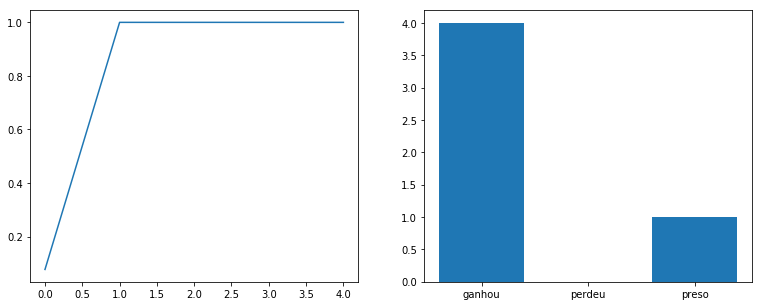

In [52]:
solucoes = []
nomes = ['ganhou', 'perdeu', 'preso']
valores = [0, 0, 0]

for i in range(5):
    solucao = algoritmo_genetico(50, 20, False, 250)
    solucoes.append(solucao)
    if solucao == 1:
        valores[0] += 1
    elif solucao == 0:
        valores[1] += 1
    else:
        valores[2] += 1

print(solucoes)
plt.figure(1, figsize=(20, 5))
plt.subplot(131)
plt.plot(solucoes)
plt.subplot(132)
plt.bar(nomes, valores)
plt.show()